# Project 4 - Part 1 - Nose Tip Detection


In [10]:
import numpy as np
import pandas as pd
import glob
import skimage.io as skio
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

### Define torch dataset dataloader for immface


In [11]:
NOSE_KP_IDX = -6
class IMMFaceDataset(Dataset):
    def __init__(self, root_dir, resize_res = [64,64], transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.resize_res = resize_res
        self.img_paths = glob.glob(self.root_dir + '*.jpg')
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img, keypoints_absolute = self.read_danes_img_and_keypoints(self.img_paths[idx])

        if self.transform:
            img = self.transform(img)
        sample = {'image': img, 'keypoints': keypoints_absolute}
        return sample

    def read_danes_img_and_keypoints(self, img_path):
        img = skio.imread(img_path, as_gray=True)
        img = resize(img, output_shape=self.resize_res)
        #img = np.reshape(img, (1,self.resize_res[0],self.resize_res[1]))
        img = img.astype(np.float32) - 0.5

        img_filename = os.path.splitext(os.path.basename(img_path))[0]
        asf_path = os.path.join(os.path.dirname(img_path), f'{img_filename}.asf')
        df = pd.read_csv(asf_path, header=None, skiprows=16, nrows=58, delimiter='\t')
        keypoints_relative = df[[2,3]]

        return img, np.array(keypoints_relative, dtype=np.float32)

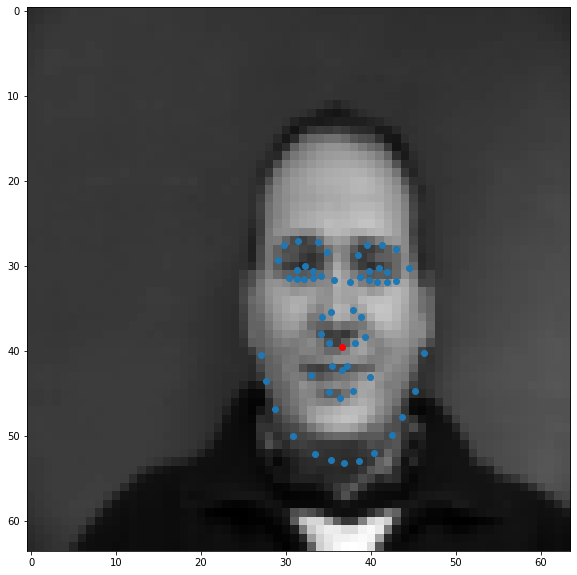

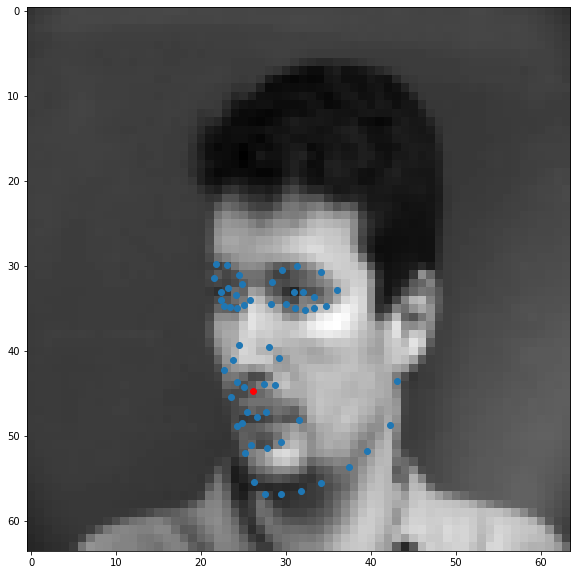

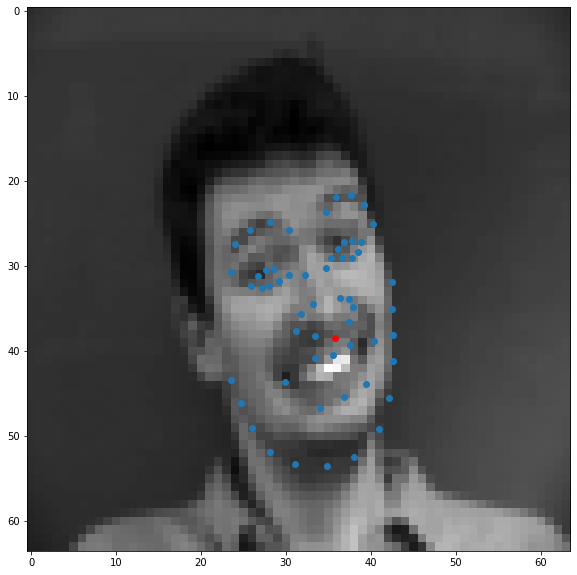

In [12]:
# Test dataset
ds = IMMFaceDataset(root_dir='imm_face_db/')

for i in [0,1,2]:
    sample = ds[i]
    img, kps = sample['image'], sample['keypoints']
    plt.figure(figsize=[10,10])
    plt.imshow((img+0.5), cmap='gray')
    nose_kp = [kps[NOSE_KP_IDX,0]*img.shape[1], kps[NOSE_KP_IDX,1]*img.shape[0]]
    plt.scatter(x=kps[:,0]*img.shape[1], y=kps[:,1]*img.shape[0])
    plt.scatter(x=nose_kp[0], y=nose_kp[1], color='red')
    plt.savefig(f'out_part1/input_{i}.jpg', bbox_inches='tight')

# Create CNN


In [13]:
class Net(nn.Module):

    def __init__(self, output_size = 2):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 12, 7)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.conv3 = nn.Conv2d(16, 24, 3)
        self.conv4 = nn.Conv2d(24, 32, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, output_size)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net().to(dev)
print(net)

Net(
  (conv1): Conv2d(1, 12, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [14]:
# Debug
# input = torch.randn(1, 1, 64, 64)
# out = net(input)
# print(out)

In [15]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [16]:
# Define train and test datasets

transform = transforms.Compose(
    [transforms.ToTensor()])
ds = IMMFaceDataset(root_dir='imm_face_db/', transform=transform)
train_dataset = torch.utils.data.Subset(ds, range(0,192))
val_dataset = torch.utils.data.Subset(ds, range(192,len(ds)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2)

In [17]:
def get_loss(net, loader):
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(loader):
            inputs, labels = data['image'], data['keypoints'][:,NOSE_KP_IDX,:]
            inputs = inputs.to(dev)
            labels = labels.to(dev)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        mean_loss = running_loss/len(loader)
    return mean_loss

In [18]:
train_losses = []
val_losses = []
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'], data['keypoints'][:,NOSE_KP_IDX,:]
        inputs = inputs.to(dev)
        labels = labels.to(dev)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # Compute metrics every 10 mini-batches
            print('[Epoch %d, Minibatch %d/%d] loss: %.3f' %
                  (epoch + 1, i + 1, len(train_loader), running_loss / 10))
            running_loss = 0.0

    # Compute loss metrics
    train_loss = get_loss(net, train_loader)
    train_losses.append(train_loss)

    val_loss = get_loss(net, val_loader)
    val_losses.append(val_loss)

    print('Epoch %d done - Train %.3f Val %.3f' % (epoch + 1, train_loss, val_loss))
print('Done')

[Epoch 1, Minibatch 10/24] loss: 0.315
[Epoch 1, Minibatch 20/24] loss: 0.324
Epoch 1 done - Train 0.307 Val 0.300
[Epoch 2, Minibatch 10/24] loss: 0.298
[Epoch 2, Minibatch 20/24] loss: 0.300
Epoch 2 done - Train 0.285 Val 0.278
[Epoch 3, Minibatch 10/24] loss: 0.284
[Epoch 3, Minibatch 20/24] loss: 0.244
Epoch 3 done - Train 0.174 Val 0.167
[Epoch 4, Minibatch 10/24] loss: 0.119
[Epoch 4, Minibatch 20/24] loss: 0.029
Epoch 4 done - Train 0.018 Val 0.020
[Epoch 5, Minibatch 10/24] loss: 0.012
[Epoch 5, Minibatch 20/24] loss: 0.005
Epoch 5 done - Train 0.005 Val 0.005
[Epoch 6, Minibatch 10/24] loss: 0.005
[Epoch 6, Minibatch 20/24] loss: 0.005
Epoch 6 done - Train 0.005 Val 0.005
[Epoch 7, Minibatch 10/24] loss: 0.004
[Epoch 7, Minibatch 20/24] loss: 0.006
Epoch 7 done - Train 0.005 Val 0.004
[Epoch 8, Minibatch 10/24] loss: 0.004
[Epoch 8, Minibatch 20/24] loss: 0.005
Epoch 8 done - Train 0.005 Val 0.005
[Epoch 9, Minibatch 10/24] loss: 0.005
[Epoch 9, Minibatch 20/24] loss: 0.004
Ep

## Plot loss

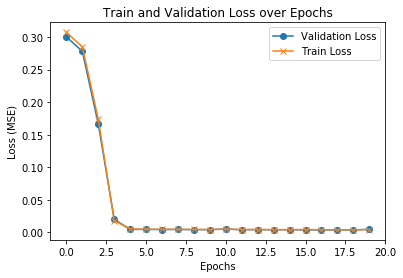

In [19]:
plt.plot(val_losses, marker='o', label='Validation Loss')
plt.plot(train_losses, marker='x', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.xlim([-1,20])
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.savefig('out_part1/loss.png', bbox_inches='tight')

# Try some sample outputs

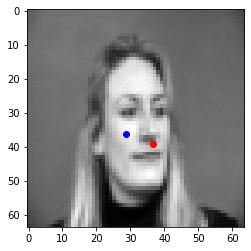

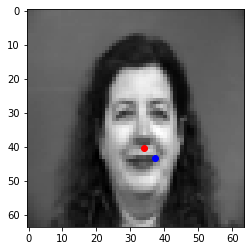

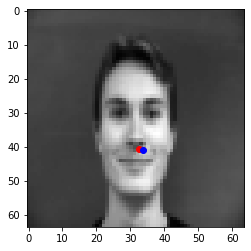

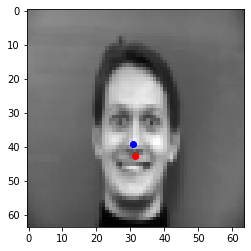

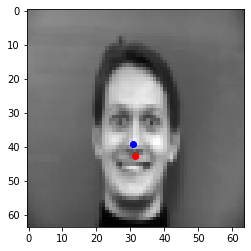

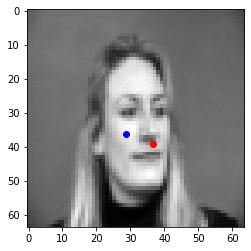

In [23]:
for idx in range(0,6):
    data = next(iter(val_loader))
    with torch.no_grad():
        inputs, labels = data['image'], data['keypoints'][:,NOSE_KP_IDX,:]
        inputs = inputs.to(dev)
        labels = labels.to(dev)
        out = net(inputs)
    plt.figure()
    img = np.array(inputs.cpu()[idx,0,:,:])
    img = (img+0.5)*255
    plt.imshow(img,cmap='gray')

    # Plot actual nose kps
    true_kps = np.array(data['keypoints'])
    true_nose_kp = [true_kps[idx,NOSE_KP_IDX,0]*img.shape[1], true_kps[idx,NOSE_KP_IDX,1]*img.shape[0]]
    plt.scatter(x=true_nose_kp[0], y=true_nose_kp[1], color='red')

    # Plot predicted nose
    pred_kps = np.array(out.cpu()[idx,:])
    plt.scatter(x=pred_kps[0]*img.shape[1], y=pred_kps[1]*img.shape[0], color='blue')
    plt.savefig(f'out_part1/nose_pred_{idx}.jpg', bbox_inches='tight')